In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.model_selection import train_test_split

In [7]:
mnist = input_data.read_data_sets("../Data/", one_hot=False)

Extracting ../Data/train-images-idx3-ubyte.gz
Extracting ../Data/train-labels-idx1-ubyte.gz
Extracting ../Data/t10k-images-idx3-ubyte.gz
Extracting ../Data/t10k-labels-idx1-ubyte.gz


In [10]:
fashion_mnist = input_data.read_data_sets('../Data/Fashion/',one_hot=False)

Extracting ../Data/Fashion/train-images-idx3-ubyte.gz
Extracting ../Data/Fashion/train-labels-idx1-ubyte.gz
Extracting ../Data/Fashion/t10k-images-idx3-ubyte.gz
Extracting ../Data/Fashion/t10k-labels-idx1-ubyte.gz


In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', data_home='../Data/')
newsgroups_test = fetch_20newsgroups(subset='test', data_home='../Data/')

vectortype_train = TfidfVectorizer(stop_words='english')
vectortype_test = TfidfVectorizer(stop_words='english')

news_vectored_result_train = vectortype_train.fit_transform(newsgroups_train.data)
news_vectored_result_test = vectortype_test.fit_transform(newsgroups_test.data)

news_train_target = newsgroups_train.target
news_train_target_names = newsgroups_train.target_names
news_test_target = newsgroups_test.target


train_features = vectortype_train.get_feature_names()
test_features = vectortype_test.get_feature_names()
common_features = np.intersect1d(train_features, test_features)

train_feature_final = np.searchsorted(train_features, common_features)
news_vt_train = news_vectored_result_train[:,train_feature_final]

test_feature_final = np.searchsorted(test_features, common_features)
news_vt_test = news_vectored_result_test[:,test_feature_final]

news_vt_train = np.array(news_vt_train.todense())
news_vt_test = np.array(news_vt_test.todense())

In [2]:
spam_file = open("../Data/spambase.data")
spam_list = []
spam_target = []
spam_col = []
for line in spam_file.readlines():
    line = line.split(',')
    line = [float(x) for x in line]
    spam_list.append(line[:-1])
    spam_target.append(int(line[-1]))
spam_data = np.array(spam_list)
spam_target = np.array(spam_target)
spam_train, spam_test, spam_train_target, spam_test_target = train_test_split(spam_data, spam_target, test_size=0.2)

In [4]:
class AutoEncoder:
    def __init__(self,X_train, X_test, Y_train, Y_test, learning_rate = 0.1, num_steps = 30000,
                 batch_size = 256, display_step = 1000, examples_to_show = 10, num_hidden_1 = 256, num_hidden_2 = 128 , num_input = 784):
        self.learning_rate = learning_rate
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.display_step = display_step
        self.examples_to_show = examples_to_show
        self.num_hidden_1 = num_hidden_1
        self.num_hidden_2 = num_hidden_2 
        self.num_input = num_input 
        self.X = tf.placeholder("float", [None, num_input])
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test

        self.weights = {
        'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
        'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
        'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
        'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
        }
        self.biases = {
        'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
        'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
        'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
        'decoder_b2': tf.Variable(tf.random_normal([num_input])),
        }
    
    def encoder(self, x):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, self.weights['encoder_h1']),
                                       self.biases['encoder_b1']))
        # Encoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['encoder_h2']),
                                       self.biases['encoder_b2']))
        return layer_2


    # Building the decoder
    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, self.weights['decoder_h1']),
                                       self.biases['decoder_b1']))
        # Decoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
                                       self.biases['decoder_b2']))
        return layer_2
    
    def shuffle(self,matrix1, matrix2):
        index = np.arange(np.shape(matrix1)[0])
        np.random.shuffle(index)
        return matrix1[index, :], matrix2[index]
    
    def getBatch(self,data, old, batch_size):
        if old+batch_size <= data.shape[0]:
            batch_x = data[old:old+batch_size]
            old += batch_size
            return batch_x, old
        else:
            batch_x = data[old:old+batch_size]
            t_batch_size = batch_size - batch_x.shape[0]
            old = 0
            new_batch_x = data[old:t_batch_size]
            batch_x = np.concatenate((batch_x, new_batch_x), axis=0)
            old += t_batch_size
            return batch_x, old
        
    def setup(self):
        encoder_op = self.encoder(self.X)
        self.decoder_op = self.decoder(encoder_op)
        # Prediction
        y_pred = self.decoder_op
        # Targets (Labels) are the input data.
        y_true = self.X

        # Define loss and optimizer, minimize the squared error
        self.loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

        # Initialize the variables (i.e. assign their default value)
        self.init = tf.global_variables_initializer()
    
    
    def run(self):
        self.sess = tf.Session()
        self.setup()
        # Run the initializer
        self.sess.run(self.init)
        
        
        self.X_shuffle, _ = self.shuffle(self.X_train, self.Y_train)
        old = 0
        
        # Training
        for i in range(1, self.num_steps+1):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
            batch_x, old = self.getBatch(self.X_shuffle, old, self.batch_size)

            # Run optimization op (backprop) and cost op (to get loss value)
            _, l = self.sess.run([self.optimizer, self.loss], feed_dict={self.X: batch_x})
            # Display logs per step
            if i % self.display_step == 0 or i == 1:
                print('Step %i: Minibatch Loss: %f' % (i, l))
        
        self.g = self.sess.run(self.decoder_op, feed_dict={self.X: self.X_shuffle})
        self.g_new = self.sess.run(self.decoder_op, feed_dict={self.X: self.X_test})
    
    def draw(self): 
        # Testing
        # Encode and decode images from test set and visualize their reconstruction.
        n = 4
        canvas_orig = np.empty((28 * n, 28 * n))
        canvas_recon = np.empty((28 * n, 28 * n))
        old = 0
        for i in range(n):
            # MNIST test set
            batch_x, old = self.getBatch(self.X_shuffle, old, self.batch_size)
            # Encode and decode the digit image
            g = self.sess.run(self.decoder_op, feed_dict={self.X: batch_x})
            # Display original images
            for j in range(n):
                # Draw the generated digits
                canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])
            # Display reconstructed images
            for j in range(n):
                # Draw the generated digits
                canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

        print("Original Images")     
        plt.figure(figsize=(n, n))
        plt.imshow(canvas_orig, origin="upper", cmap="gray")
        plt.show()

        print("Reconstructed Images")
        plt.figure(figsize=(n, n))
        plt.imshow(canvas_recon, origin="upper", cmap="gray")
        plt.show()
        

    def Find_Gini_Purity(self, target_cluster, predicted_cluster):
        matrix = confusion_matrix(target_cluster, predicted_cluster)
        matrix = matrix[:, 1:]
        N = []
        M = []
        P = []
        rows = matrix.shape[0]

        columns = matrix.shape[1]

        for i in range(rows):
            N.append(sum(matrix[i]))

        for j in range(columns):
            M.append(sum(matrix[:,j]))

        for j in range(columns):
            P.append(max(matrix[:,j]))

        Purity = sum(P) / sum(M)
        return Purity        
        
    def cluster(self, n_clusters):
        print('Original Purity:')
        km = KMeans(n_clusters)
        km.fit(self.X_train, self.Y_train)
        predict = km.predict(self.X_test)
        print(self.Find_Gini_Purity(self.Y_test, predict))
        
        print('Encoded Purity:')
        km_new = KMeans(n_clusters)
        km_new.fit(self.g, self.Y_train)
        predict_new = km_new.predict(self.g_new)
        print(self.Find_Gini_Purity(self.Y_test, predict_new))
        self.sess.close()


Step 1: Minibatch Loss: 0.303520
Step 1000: Minibatch Loss: 0.051841
Step 2000: Minibatch Loss: 0.052807
Step 3000: Minibatch Loss: 0.052053
Step 4000: Minibatch Loss: 0.052856
Step 5000: Minibatch Loss: 0.051532
Step 6000: Minibatch Loss: 0.049900
Step 7000: Minibatch Loss: 0.051699
Step 8000: Minibatch Loss: 0.048416
Step 9000: Minibatch Loss: 0.050795
Step 10000: Minibatch Loss: 0.051209
Original Images


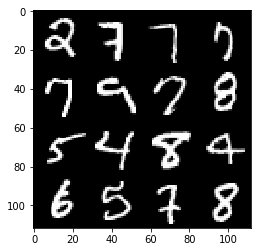

Reconstructed Images


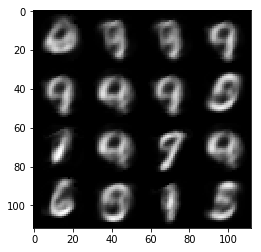

Original Purity:
0.602289305353
Encoded Purity:
0.462771680654


In [5]:
ae = AutoEncoder(
    mnist.train.images,
    mnist.test.images,
    mnist.train.labels,
    mnist.test.labels,
    num_steps=10000,
    num_hidden_1=5,
    num_hidden_2=5,
    display_step=1000)

ae.run()
ae.draw()
ae.cluster(10)

Step 1: Minibatch Loss: 0.371164
Step 1000: Minibatch Loss: 0.075214
Step 2000: Minibatch Loss: 0.037834
Step 3000: Minibatch Loss: 0.031400
Step 4000: Minibatch Loss: 0.028202
Step 5000: Minibatch Loss: 0.025958
Step 6000: Minibatch Loss: 0.028678
Step 7000: Minibatch Loss: 0.026030
Step 8000: Minibatch Loss: 0.024041
Step 9000: Minibatch Loss: 0.024865
Step 10000: Minibatch Loss: 0.024836
Original Images


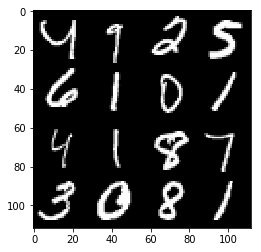

Reconstructed Images


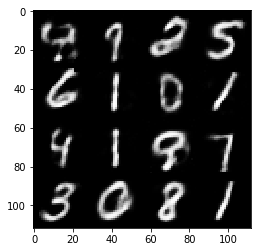

Original Purity:
0.579861111111
Encoded Purity:
0.56043715847


In [6]:
ae_50 = AutoEncoder(
    mnist.train.images,
    mnist.test.images,
    mnist.train.labels,
    mnist.test.labels,
    num_steps=10000,
    num_hidden_1=50,
    num_hidden_2=5,
    display_step=1000)

ae_50.run()
ae_50.draw()
ae_50.cluster(10)

Step 1: Minibatch Loss: 0.468310
Step 1000: Minibatch Loss: 0.203041
Step 2000: Minibatch Loss: 0.200660
Step 3000: Minibatch Loss: 0.204550
Step 4000: Minibatch Loss: 0.197887
Step 5000: Minibatch Loss: 0.196710
Step 6000: Minibatch Loss: 0.194245
Step 7000: Minibatch Loss: 0.192651
Step 8000: Minibatch Loss: 0.192815
Step 9000: Minibatch Loss: 0.196884
Step 10000: Minibatch Loss: 0.192281
Original Images


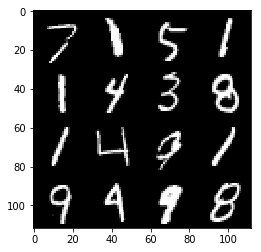

Reconstructed Images


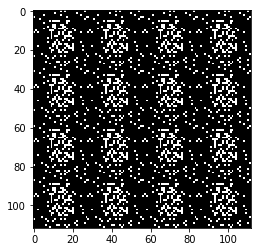

Original Purity:
0.623920653442
Encoded Purity:
0.246142933144


In [8]:
ae_500 = AutoEncoder(
    mnist.train.images,
    mnist.test.images,
    mnist.train.labels,
    mnist.test.labels,
    num_steps=10000,
    num_hidden_1=500,
    num_hidden_2=50,
    display_step=1000)

ae_500.run()
ae_500.draw()
ae_500.cluster(10)

In [ ]:
news_ae_5 = AutoEncoder(
    news_vt_train,
    news_vt_test,
    news_train_target,
    news_test_target,
    num_steps=100,
    num_hidden_1=5,
    num_hidden_2=5,
    display_step=10, 
    num_input=49600)

news_ae_5.run()
#news_ae_5.cluster(20)

Step 1: Minibatch Loss: 0.338935
Step 10: Minibatch Loss: 0.338875
Step 20: Minibatch Loss: 0.338680
Step 30: Minibatch Loss: 0.338288
Step 40: Minibatch Loss: 0.337659
Step 50: Minibatch Loss: 0.336584
Step 60: Minibatch Loss: 0.334579
Step 70: Minibatch Loss: 0.330928
Step 80: Minibatch Loss: 0.324329
Step 90: Minibatch Loss: 0.312860
Step 100: Minibatch Loss: 0.298768


In [5]:
news_ae_50 = AutoEncoder(
    news_vt_train,
    news_vt_test,
    news_train_target,
    news_test_target,
    num_steps=100,
    num_hidden_1=50,
    num_hidden_2=5,
    display_step=10,
    num_input=49600)

news_ae_50.run()
news_ae_50.cluster(20)

Step 1: Minibatch Loss: 0.412631
Step 10: Minibatch Loss: 0.412557
Step 20: Minibatch Loss: 0.412557
Step 30: Minibatch Loss: 0.412320
Step 40: Minibatch Loss: 0.412005
Step 50: Minibatch Loss: 0.411584
Step 60: Minibatch Loss: 0.410788
Step 70: Minibatch Loss: 0.409398
Step 80: Minibatch Loss: 0.406957
Step 90: Minibatch Loss: 0.402577
Step 100: Minibatch Loss: 0.394540


ResourceExhaustedError: OOM when allocating tensor with shape[11314,49600]
	 [[Node: MatMul_3 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](Sigmoid_2, Variable_3/read)]]

Caused by op 'MatMul_3', defined at:
  File "/home/hemnaniv/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hemnaniv/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/hemnaniv/anaconda3/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/hemnaniv/anaconda3/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/home/hemnaniv/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-9614cd77210f>", line 12, in <module>
    news_ae_50.run()
  File "<ipython-input-4-ee2438c00c20>", line 88, in run
    self.setup()
  File "<ipython-input-4-ee2438c00c20>", line 72, in setup
    self.decoder_op = self.decoder(encoder_op)
  File "<ipython-input-4-ee2438c00c20>", line 47, in decoder
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1801, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1263, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/hemnaniv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[11314,49600]
	 [[Node: MatMul_3 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](Sigmoid_2, Variable_3/read)]]


In [6]:
news_ae_100 = AutoEncoder(
    news_vt_train,
    news_vt_test,
    news_train_target,
    news_test_target,
    num_steps=10000,
    num_hidden_1=100,
    num_hidden_2=30,
    display_step=1000,
    num_input=49600)

news_ae_100.run()
#news_ae_100.cluster(20)

MemoryError: 

In [27]:
spam_ae_5 = AutoEncoder(
    spam_train,
    spam_test,
    spam_train_target,
    spam_test_target,
    num_steps=1000,
    num_hidden_1=5,
    num_hidden_2=5,
    display_step=100,
    num_input=57)

spam_ae_5.run()
spam_ae_5.cluster(20)

Step 1: Minibatch Loss: 6984.458496
Step 100: Minibatch Loss: 6228.734863
Step 200: Minibatch Loss: 4853.964844
Step 300: Minibatch Loss: 10644.312500
Step 400: Minibatch Loss: 9252.244141
Step 500: Minibatch Loss: 3382.506836
Step 600: Minibatch Loss: 4148.272461
Step 700: Minibatch Loss: 5569.338867
Step 800: Minibatch Loss: 5555.852051
Step 900: Minibatch Loss: 7435.767578
Step 1000: Minibatch Loss: 3265.291748
Original Purity:
0.592128801431
Encoded Purity:
0.859375


In [4]:
spam_ae_50 = AutoEncoder(
    spam_train,
    spam_test,
    spam_train_target,
    spam_test_target,
    num_steps=1000,
    num_hidden_1=50,
    num_hidden_2=5,
    display_step=100,
    num_input=57)

spam_ae_50.run()
spam_ae_50.cluster(20)

Step 1: Minibatch Loss: 6217.130371
Step 100: Minibatch Loss: 17537.248047
Step 200: Minibatch Loss: 6157.981445
Step 300: Minibatch Loss: 6624.434082
Step 400: Minibatch Loss: 6343.861816
Step 500: Minibatch Loss: 4119.539062
Step 600: Minibatch Loss: 4749.212402
Step 700: Minibatch Loss: 7134.498535
Step 800: Minibatch Loss: 7785.053711
Step 900: Minibatch Loss: 5254.131348
Step 1000: Minibatch Loss: 3290.260986
Original Purity:
0.587668593449
Encoded Purity:
0.822222222222


In [5]:
spam_ae_100 = AutoEncoder(
    spam_train,
    spam_test,
    spam_train_target,
    spam_test_target,
    num_steps=1000,
    num_hidden_1=100,
    num_hidden_2=50,
    display_step=100,
    num_input=57)

spam_ae_100.run()
spam_ae_100.cluster(20)

Step 1: Minibatch Loss: 11678.704102
Step 100: Minibatch Loss: 7276.667969
Step 200: Minibatch Loss: 5410.724609
Step 300: Minibatch Loss: 7003.325684
Step 400: Minibatch Loss: 20162.494141
Step 500: Minibatch Loss: 5233.878418
Step 600: Minibatch Loss: 6810.959473
Step 700: Minibatch Loss: 4978.397949
Step 800: Minibatch Loss: 3100.489014
Step 900: Minibatch Loss: 5549.298828
Step 1000: Minibatch Loss: 5888.757324
Original Purity:
0.67816091954
Encoded Purity:
0.793281653747


Step 1: Minibatch Loss: 0.242199
Step 1000: Minibatch Loss: 0.047645
Step 2000: Minibatch Loss: 0.045760
Step 3000: Minibatch Loss: 0.052161
Step 4000: Minibatch Loss: 0.038053
Step 5000: Minibatch Loss: 0.042112
Step 6000: Minibatch Loss: 0.041981
Step 7000: Minibatch Loss: 0.041873
Step 8000: Minibatch Loss: 0.040880
Step 9000: Minibatch Loss: 0.040837
Step 10000: Minibatch Loss: 0.041487
Original Images


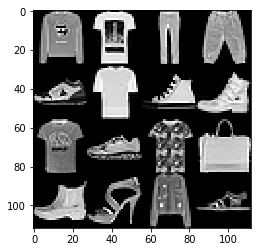

Reconstructed Images


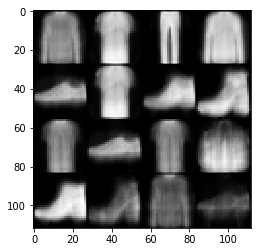

Original Purity:
0.540112359551
Encoded Purity:
0.61178470255


In [11]:
f_ae_5 = AutoEncoder(
    fashion_mnist.train.images,
    fashion_mnist.test.images,
    fashion_mnist.train.labels,
    fashion_mnist.test.labels,
    num_steps=10000,
    num_hidden_1=5,
    num_hidden_2=5,
    display_step=1000)

f_ae_5.run()
f_ae_5.draw()
f_ae_5.cluster(10)

Step 1: Minibatch Loss: 0.330014
Step 1000: Minibatch Loss: 0.052323
Step 2000: Minibatch Loss: 0.044995
Step 3000: Minibatch Loss: 0.045848
Step 4000: Minibatch Loss: 0.042949
Step 5000: Minibatch Loss: 0.038192
Step 6000: Minibatch Loss: 0.036135
Step 7000: Minibatch Loss: 0.033697
Step 8000: Minibatch Loss: 0.037795
Step 9000: Minibatch Loss: 0.035340
Step 10000: Minibatch Loss: 0.033451
Original Images


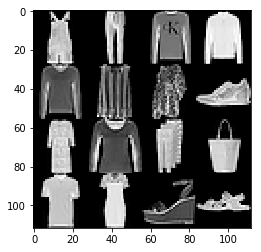

Reconstructed Images


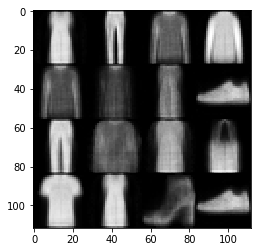

Original Purity:
0.552792116377
Encoded Purity:
0.527582417582


In [12]:
f_ae_50 = AutoEncoder(
    fashion_mnist.train.images,
    fashion_mnist.test.images,
    fashion_mnist.train.labels,
    fashion_mnist.test.labels,
    num_steps=10000,
    num_hidden_1=50,
    num_hidden_2=5,
    display_step=1000)

f_ae_50.run()
f_ae_50.draw()
f_ae_50.cluster(10)

Step 1: Minibatch Loss: 0.370375
Step 1000: Minibatch Loss: 0.051214
Step 2000: Minibatch Loss: 0.045609
Step 3000: Minibatch Loss: 0.050957
Step 4000: Minibatch Loss: 0.047114
Step 5000: Minibatch Loss: 0.040808
Step 6000: Minibatch Loss: 0.039415
Step 7000: Minibatch Loss: 0.035365
Step 8000: Minibatch Loss: 0.040574
Step 9000: Minibatch Loss: 0.041015
Step 10000: Minibatch Loss: 0.039043
Original Images


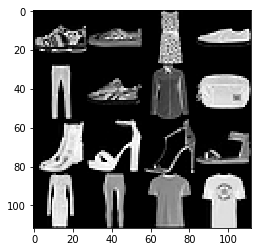

Reconstructed Images


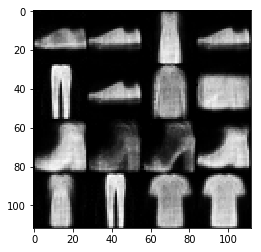

Original Purity:
0.566937235624
Encoded Purity:
0.655059355568


In [13]:
f_ae_100 = AutoEncoder(
    fashion_mnist.train.images,
    fashion_mnist.test.images,
    fashion_mnist.train.labels,
    fashion_mnist.test.labels,
    num_steps=10000,
    num_hidden_1=100,
    num_hidden_2=50,
    display_step=1000)

f_ae_100.run()
f_ae_100.draw()
f_ae_100.cluster(10)